# Housing Facilities

This notebook maps the locations of the senior housing across the City of Los Angeles. We will use this map as another consideration for which neighborhood we would like to "zoom in" to. 

In [1]:
#imprt libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import fiona 
import numpy as np
import math
import folium
from shapely.geometry import Point
import plotly.express as px

In [64]:
#read GeoJSON that Dom linked
housing = gpd.read_file('Senior_Housing.geojson')
housing.sample(5)
len(housing)

91

In [65]:
cityboundary_proj=gpd.read_file("https://maps.lacity.org/lahub/rest/services/Boundaries/MapServer/7/query?outFields=*&where=1%3D1&f=geojson").to_crs('epsg:6423')
cityreproj=cityboundary_proj.to_crs('4326')
housingla=gpd.clip(housing, cityreproj)
len(housingla)

88

### Map how many housing facilities are in each neighborhood

In [66]:
# Import neighborhood boundaries directly from LA GeoHub.
neighborhoods=gpd.read_file(
    'https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson').to_crs('epsg:6423').rename(columns={'name' : 'neighborhood'})
neighborhoods = neighborhoods.to_crs(4326) #converting to the projection of our Seniors data

In [67]:
#spatial join to facilities
housing_join = gpd.sjoin(housingla, neighborhoods, how='left')
housing_join.head()

,OBJECTID_left,Name,Address,City,State,Zipcode,Lat,Lon,GlobalID,geometry,index_right,OBJECTID_right,neighborhood
5,6,Bayside Terrace,860 W. 5th Street,San Pedro,CA,90731,33.739964,-118.295905,15e90f19-5573-4d1b-ad02-deb99038b76f,POINT (-118.29591 33.73996),79,80,San Pedro
59,61,Progressive Home for the Elderly,7010 S. Denver Ave.,Los Angeles,CA,90061,33.921393,-118.284645,68719b03-bc53-42fa-9ef8-29546c9450a2,POINT (-118.28465 33.92139),42,43,Harbor Gateway
7,8,Broadway Villas,9413 S. Spring Street,Los Angeles,CA,90003,33.950361,-118.276849,210f9c0b-6bd7-48eb-a485-da30e53bf1a3,POINT (-118.27685 33.95036),11,12,Broadway-Manchester
29,31,Harvard Glenmary,8711 S. Harvard Avenue,Los Angeles,CA,90047,33.958562,-118.307546,9534969e-22ee-4f34-9718-161e4eeac04d,POINT (-118.30755 33.95856),35,36,Gramercy Park
52,54,P & P Home,1030 W. 85th Street,Los Angeles,CA,90044,33.960693,-118.293404,bf65eef0-d3f3-480c-8363-eceb6f267cf4,POINT (-118.29340 33.96069),98,99,Vermont Knolls


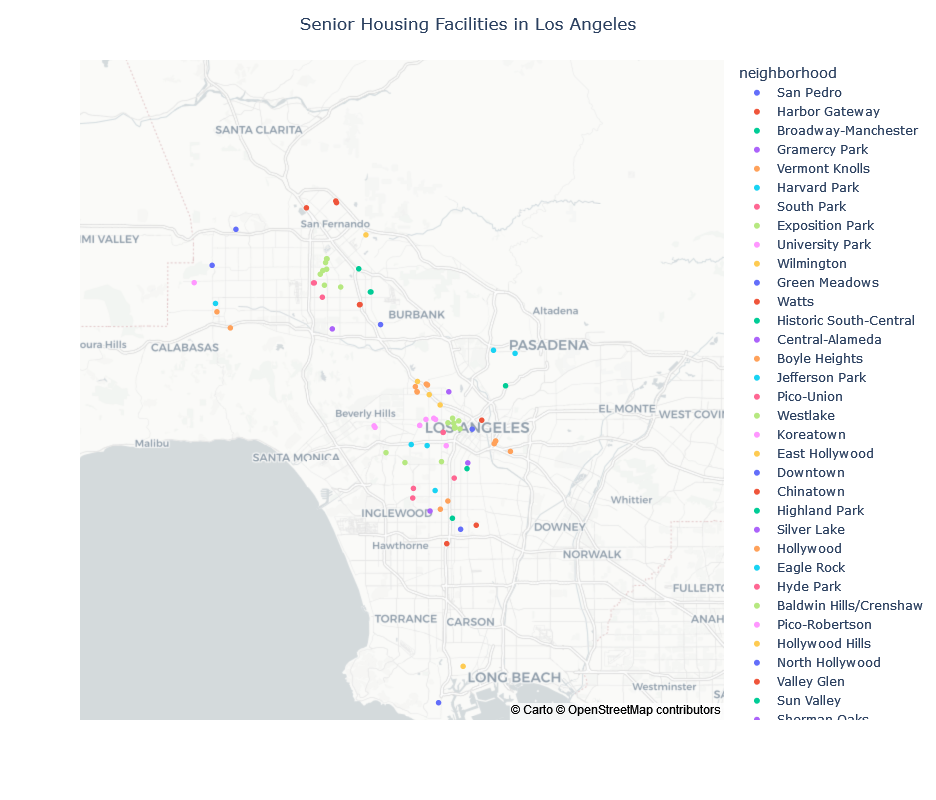

In [88]:
fig = px.scatter_mapbox(housing_join,
                        lat='Lat',
                        lon='Lon',
                        color= 'neighborhood',
                        mapbox_style="carto-positron",
                        labels={
                            'housing':'Name'
                        })
fig.update_layout(
    width = 950,
    height = 800,
    mapbox_style="carto-positron",
    mapbox_zoom=9,
    title = "Senior Housing Facilities in Los Angeles",
    title_x=0.5)

fig.show()

In [69]:
#group by neighborhood and count
housing_group = housing_join.groupby(['neighborhood'])['neighborhood'].count().reset_index(name='housing count')

In [70]:
housing_neighbor=pd.merge(neighborhoods,housing_group,how="left", 
                              on=['neighborhood']).fillna(0)

In [71]:
housing_neighbor.head()

,OBJECTID,neighborhood,geometry,housing count
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",0.0
1,2,Arleta,"POLYGON ((-118.44255 34.26412, -118.44240 34.2...",0.0
2,3,Arlington Heights,"POLYGON ((-118.31862 34.05306, -118.31673 34.0...",0.0
3,4,Atwater Village,"MULTIPOLYGON (((-118.27886 34.15321, -118.2788...",0.0
4,5,Baldwin Hills/Crenshaw,"POLYGON ((-118.36102 34.02532, -118.36026 34.0...",2.0


<AxesSubplot: >

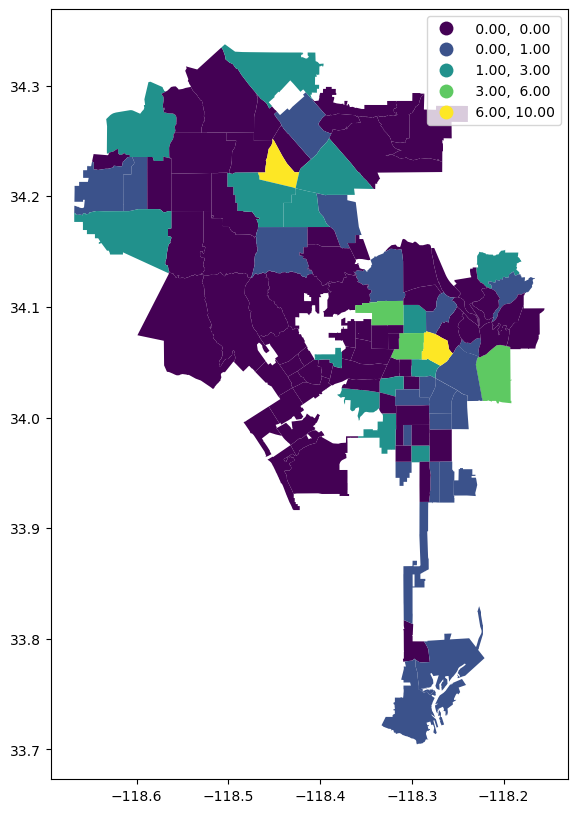

In [72]:
housing_neighbor.plot(figsize=(12,10),
                column='housing count',
                legend=True,
                scheme='NaturalBreaks')

In [107]:
housing_neighbor.loc[housing_neighbor['housing count']==0, 'cat'] = '0'
housing_neighbor.loc[housing_neighbor['housing count']==1, 'cat'] = '1'
housing_neighbor.loc[housing_neighbor['housing count']==2, 'cat'] = '2'
housing_neighbor.loc[housing_neighbor['housing count']==3, 'cat'] = '3'
housing_neighbor.loc[housing_neighbor['housing count']==4, 'cat'] = '4'
housing_neighbor.loc[housing_neighbor['housing count']>4, 'cat'] = '5-10'

In [108]:
cats = housing_neighbor['cat'].unique().tolist()
cats
housing_neighbor.head()

,OBJECTID,neighborhood,geometry,housing count,pctcat,cat
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",0.0,0,0
1,2,Arleta,"POLYGON ((-118.44255 34.26412, -118.44240 34.2...",0.0,0,0
2,3,Arlington Heights,"POLYGON ((-118.31862 34.05306, -118.31673 34.0...",0.0,0,0
3,4,Atwater Village,"MULTIPOLYGON (((-118.27886 34.15321, -118.2788...",0.0,0,0
4,5,Baldwin Hills/Crenshaw,"POLYGON ((-118.36102 34.02532, -118.36026 34.0...",2.0,2,2


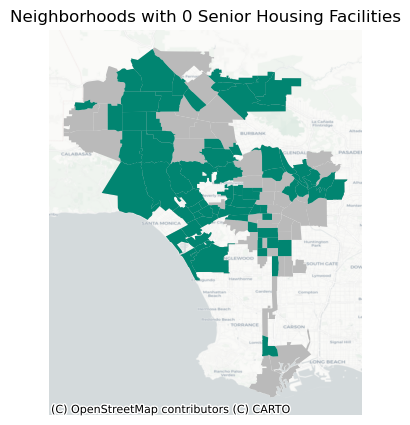

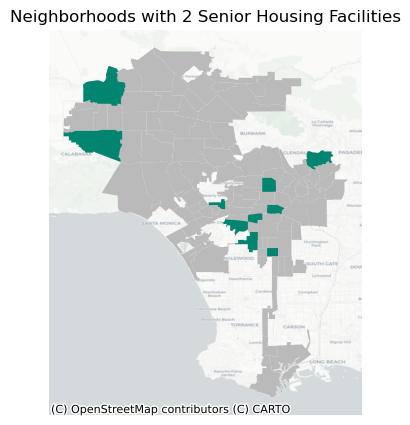

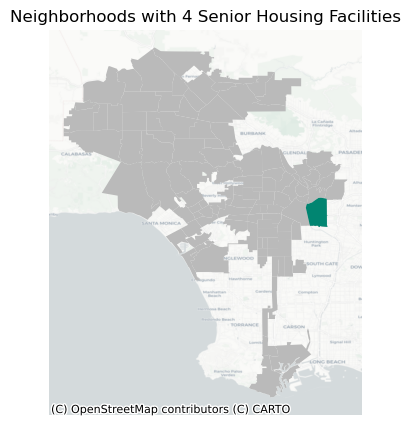

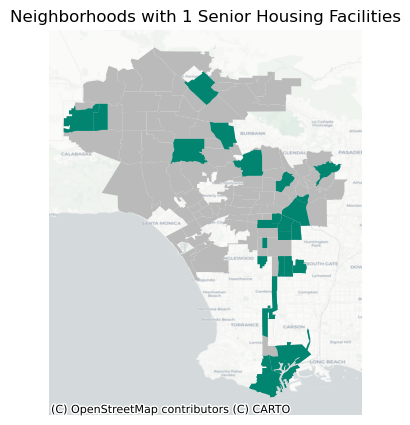

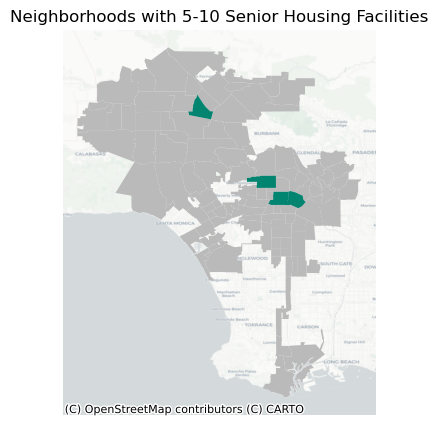

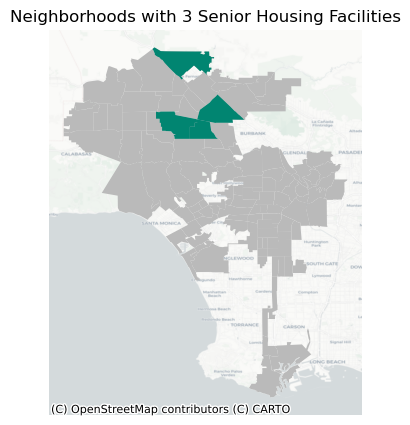

In [109]:
for cat in cats:
    fig, ax = plt.subplots(figsize=(5,5))

        # create the map plot
    housing_neighbor.plot(ax=ax,
                color='#bababa')

        # create the map plot
    housing_neighbor[housing_neighbor['cat'] == cat].plot(ax=ax,
                # column='pctcat',
            color='#018571')

        # add a title
    ax.set_title('Neighborhoods with ' + cat + ' ' + 'Senior Housing Facilities')
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

        # get rid of the axis
    ax.axis('off');